# How Economic Fluctuations Influence Job Satisfaction Among Employees in Spain
# Preliminary Variable Selection

# Importing Libraries

In [1]:
# To clear all variables
# from IPython import get_ipython
# get_ipython().magic('reset -sf')

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import statsmodels.api as sm
import os
from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy.stats._stats import _kendall_dis

from jenkspy import JenksNaturalBreaks

import plotly.graph_objects as go

from bs4 import BeautifulSoup
import html5lib
import json
import re
import string

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

import xlsxwriter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ujvar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data_folder = '/content'

# Preliminary Variable Selection and Data Cleaning

Need to upload the 3 files to 'Files' section of Colab -

1. Full Dataset - Spain.csv
2. Full Dataset - Spain.html

    ( Downloaded from the ESS Portal )

3. Variable Selection version_3.xlsx

    ( An excel with the variables we selected relevant to the model )

Histogram of variables with null values - 


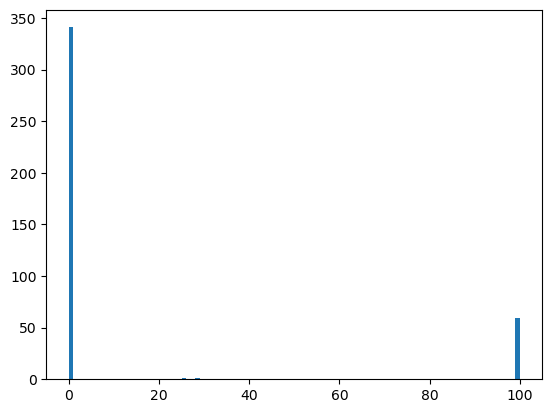

In [4]:
csv_file = os.path.join(data_folder, 'Full Dataset - Spain.csv')
html_file = os.path.join(data_folder, 'Full Dataset - Spain.html')

raw_data = pd.read_csv(csv_file)

myFile= open(html_file,encoding="utf8")
soup = BeautifulSoup(myFile.read(), features='html')

list = soup.find('ul',class_="toc-list").find_all('li')

column_mapping = {}

for item in list:

    data = item.find('a').find_all('span')
    column_name = data[0].text
    column_description = data[1].text.strip().split('- ')[-1]
    column_mapping[column_name] = column_description

raw_data_updated_columns = raw_data.rename(columns=column_mapping)

country_selected = 'ES'

country_raw_data_updated_columns = raw_data_updated_columns[raw_data_updated_columns['Country'] == country_selected]

isnull_stats_df = pd.DataFrame(country_raw_data_updated_columns.isnull().sum(), columns=['is null count'])
isnull_stats_df['percentage missing values'] = isnull_stats_df['is null count'] * 100 / len(country_raw_data_updated_columns)
print("Histogram of variables with null values - ")
plt.hist(isnull_stats_df['percentage missing values'], bins=100)
plt.show()

country_raw_data_updated_columns.to_excel(os.path.join(data_folder, 'Full Data - Spain - columns updated.xlsx'), index=False)

## First iteration of Variable Selection

In [6]:
variables_to_explore = pd.read_excel(os.path.join(data_folder, 'Variable Selection version_2.xlsx')).fillna(0)
display(variables_to_explore.head())

,Variable Name,Not Applicable CODE,Refusal,Don't know,No answer,Economic Fluctuations Variables,Other Independent Variables,Dependent Variable,Add FLAG,Remove FLAG
0,Title of dataset,0.0,0,0,0,0.0,0.0,0.0,0,0
1,ESS round,0.0,0,0,0,0.0,0.0,0.0,0,0
2,Edition,0.0,0,0,0,0.0,0.0,0.0,0,0
3,Production date,0.0,0,0,0,0.0,0.0,0.0,0,0
4,Respondent's identification number,0.0,0,0,0,0.0,0.0,0.0,0,0


In [7]:
independent_variables = []

for i in range(len(variables_to_explore)):
    row_data = variables_to_explore.iloc[i]

    if (np.round(row_data['Economic Fluctuations Variables'],0).astype(int) == 1
        or np.round(row_data['Other Independent Variables'],0).astype(int) == 1
        or np.round(row_data['Add FLAG'], 0).astype(int) == 1) and np.round(row_data['Remove FLAG'],0).astype(int) == 0:

        independent_variables += [row_data['Variable Name']]

print("The independent variables in qualititative selection", len(independent_variables))
dependent_variable = [ variables_to_explore[variables_to_explore['Dependent Variable'].astype(int) == 1]['Variable Name'].values[0] ]

The independent variables in qualititative selection 90


In [8]:
updated_raw_data = pd.read_excel(os.path.join(data_folder, 'Full Data - Spain - columns updated.xlsx'))

In [9]:
updated_raw_data_copy = updated_raw_data
updated_raw_data_copy = updated_raw_data_copy[independent_variables + dependent_variable]

for column in updated_raw_data_copy.columns:

    na_code = variables_to_explore[variables_to_explore['Variable Name'] == column]['Not Applicable CODE'].values[0]
    if na_code == 0:
        na_code = '-'
    refusal_code = variables_to_explore[variables_to_explore['Variable Name'] == column]['Refusal'].values[0]
    if refusal_code == 0:
        refusal_code = '-'
    dk_code = variables_to_explore[variables_to_explore['Variable Name'] == column]["Don't know"].values[0]
    if dk_code == 0:
        dk_code = '-'
    no_answer_code = variables_to_explore[variables_to_explore['Variable Name'] == column]["No answer"].values[0]
    if no_answer_code == 0:
        no_answer_code = '-'

    updated_raw_data_copy[column] = updated_raw_data_copy[column].replace(na_code,
                                                                          np.nan).replace(refusal_code,
                                                                                          np.nan).replace(dk_code,
                                                                                                          np.nan).replace(no_answer_code,
                                                                                                                          np.nan)
display(updated_raw_data_copy.head())

,How emotionally attached to [country],Born in country,Citizen of country,How happy are you,Subjective general health,Hampered in daily activities by illness/disability/infirmity/mental problem,How many people with whom you can discuss intimate and personal matters,How religious are you,Take part in social activities compared to others of same age,"How often socially meet with friends, relatives or colleagues",...,"Speak with colleagues about work and see each other on a screen, how often","Speak with colleagues about work using a phone, how often",Online/mobile communication makes it easy to work from home or place of choice,"Too tired after work to enjoy things like doing at home, how often","Job prevents you from giving time to partner/family, how often","Partner/family fed up with pressure of your job, how often",Current job: can decide time start/finish work,Region,The government takes measures to reduce differences in income levels,How satisfied are you in your main job
0,10.0,1.0,1.0,10.0,3.0,2.0,6.0,3.0,3.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ES61,9,NaN
1,10.0,1.0,1.0,9.0,3.0,3.0,5.0,9.0,4.0,6.0,...,3.0,1.0,5.0,3.0,2.0,2.0,2.0,ES30,2,8.0
2,9.0,1.0,1.0,2.0,4.0,1.0,1.0,8.0,1.0,2.0,...,6.0,3.0,3.0,5.0,4.0,4.0,1.0,ES61,10,3.0
3,9.0,1.0,1.0,8.0,3.0,3.0,1.0,0.0,2.0,4.0,...,7.0,3.0,9.0,4.0,4.0,3.0,2.0,ES61,10,6.0
4,9.0,1.0,1.0,9.0,1.0,3.0,3.0,0.0,1.0,7.0,...,7.0,7.0,7.0,2.0,2.0,2.0,2.0,ES53,10,9.0


In [10]:
## Removing Rows with null values in the dependent variable - 'How satified are you with your main job'?

updated_raw_data_copy = updated_raw_data_copy.dropna(subset = dependent_variable)
updated_raw_data_copy

,How emotionally attached to [country],Born in country,Citizen of country,How happy are you,Subjective general health,Hampered in daily activities by illness/disability/infirmity/mental problem,How many people with whom you can discuss intimate and personal matters,How religious are you,Take part in social activities compared to others of same age,"How often socially meet with friends, relatives or colleagues",...,"Speak with colleagues about work and see each other on a screen, how often","Speak with colleagues about work using a phone, how often",Online/mobile communication makes it easy to work from home or place of choice,"Too tired after work to enjoy things like doing at home, how often","Job prevents you from giving time to partner/family, how often","Partner/family fed up with pressure of your job, how often",Current job: can decide time start/finish work,Region,The government takes measures to reduce differences in income levels,How satisfied are you in your main job
1,10.0,1.0,1.0,9.0,3.0,3.0,5.0,9.0,4.0,6.0,...,3.0,1.0,5.0,3.0,2.0,2.0,2.0,ES30,2,8.0
2,9.0,1.0,1.0,2.0,4.0,1.0,1.0,8.0,1.0,2.0,...,6.0,3.0,3.0,5.0,4.0,4.0,1.0,ES61,10,3.0
3,9.0,1.0,1.0,8.0,3.0,3.0,1.0,0.0,2.0,4.0,...,7.0,3.0,9.0,4.0,4.0,3.0,2.0,ES61,10,6.0
4,9.0,1.0,1.0,9.0,1.0,3.0,3.0,0.0,1.0,7.0,...,7.0,7.0,7.0,2.0,2.0,2.0,2.0,ES53,10,9.0
7,10.0,1.0,1.0,10.0,1.0,3.0,2.0,6.0,4.0,7.0,...,7.0,1.0,10.0,1.0,1.0,1.0,3.0,ES52,5,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,5.0,1.0,1.0,8.0,1.0,2.0,3.0,8.0,3.0,4.0,...,6.0,2.0,10.0,3.0,3.0,3.0,2.0,ES30,6,7.0
2272,10.0,1.0,1.0,7.0,2.0,3.0,2.0,7.0,2.0,2.0,...,6.0,3.0,6.0,4.0,4.0,4.0,2.0,ES61,7,7.0
2273,3.0,1.0,1.0,6.0,3.0,3.0,2.0,5.0,2.0,4.0,...,3.0,6.0,9.0,4.0,5.0,5.0,2.0,ES30,6,9.0
2279,0.0,1.0,1.0,8.0,3.0,3.0,2.0,0.0,3.0,5.0,...,7.0,5.0,10.0,2.0,1.0,1.0,3.0,ES51,10,7.0


Histogram of variables with null values - 


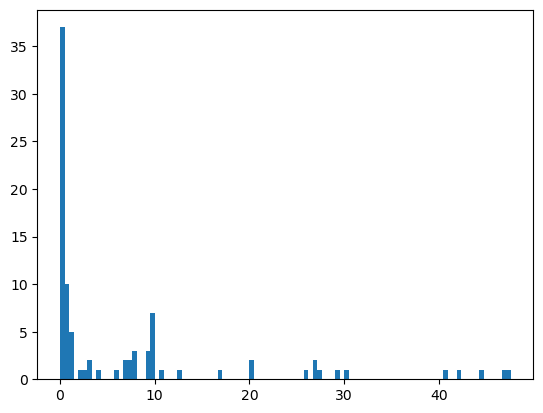

Number of columns with less than threshold missing values :  75
Number of columns with more than or equal to threshold missing values :  16


In [11]:
isnull_stats_df = pd.DataFrame(updated_raw_data_copy.isnull().sum(), columns=['is null count'])
isnull_stats_df['percentage missing values'] = isnull_stats_df['is null count'] * 100 / len(country_raw_data_updated_columns)
print("Histogram of variables with null values - ")
plt.hist(isnull_stats_df['percentage missing values'], bins=100)
plt.show()

threshold = 10

final_non_null_columns =isnull_stats_df[isnull_stats_df['percentage missing values'] < threshold].index.tolist()
print("Number of columns with less than threshold missing values : ", len(final_non_null_columns))

final_null_columns =isnull_stats_df[isnull_stats_df['percentage missing values'] >= threshold].index.tolist()
print("Number of columns with more than or equal to threshold missing values : ", len(final_null_columns))

In [12]:
updated_raw_data_copy[final_non_null_columns].to_csv(os.path.join( data_folder,
                                                                  'Full Dataset - Spain - Variable Selection - Stage 1 - FINAL.csv'), index=False)